# [Genre] Machine Learning Classifiers

In [49]:
import pandas as pd
import numpy as np
import pickle
import csv
import json
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

from tensorflow.keras.utils import to_categorical

In [24]:
DATA_PATH = '../data/'
RESULTS_DIR = '../genre-results/'

# 1. Loading the data

In [25]:
data = pd.read_csv(DATA_PATH + 'df_features.csv')
data.shape

(1000, 98)

In [26]:
data.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
0,metal.00012.wav,0.091,0.115,1.117,0.218,0.177,0.027,0.114,0.010,123.047,...,0.219,0.195,0.226,0.221,0.214,0.219,0.229,0.232,0.214,0.222
1,metal.00058.wav,0.147,0.187,1.163,0.330,0.143,0.034,0.185,0.032,143.555,...,0.261,0.217,0.313,0.271,0.252,0.311,0.267,0.308,0.247,0.261
2,metal.00054.wav,0.163,0.209,1.376,0.745,0.196,0.041,0.207,0.027,123.047,...,0.236,0.262,0.237,0.229,0.254,0.279,0.310,0.277,0.252,0.253
3,metal.00045.wav,0.069,0.094,1.604,1.602,0.144,0.062,0.088,0.032,123.047,...,0.288,0.254,0.333,0.269,0.254,0.348,0.220,0.326,0.218,0.299
4,metal.00095.wav,0.146,0.195,1.821,1.890,0.121,0.049,0.185,0.061,151.999,...,0.226,0.214,0.270,0.222,0.296,0.255,0.273,0.268,0.260,0.270


In [27]:
# Loading the label map
with open(DATA_PATH + 'genre_label_map.json', 'r') as output:
    label_map = json.load(output)

label_map

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

# 2. Preparing the data

In [28]:
# Normalizing the features
scalar = MinMaxScaler()
data[data.columns[1:]] = scalar.fit_transform(data[data.columns[1:]])

# Adding a column `label`
data['label'] = data['file_name'].apply(lambda x: label_map[x.split('.')[0]])
print(data.shape)
data.head()

(1000, 99)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,metal.00012.wav,0.271028,0.268170,0.122184,0.032536,0.615079,0.123457,0.277354,0.048780,0.463772,...,0.342593,0.387692,0.413690,0.383607,0.397436,0.434402,0.325153,0.370821,0.355346,6
1,metal.00058.wav,0.445483,0.448622,0.132651,0.036843,0.480159,0.166667,0.458015,0.182927,0.642518,...,0.410494,0.655385,0.562500,0.508197,0.692308,0.545190,0.558282,0.471125,0.477987,6
2,metal.00054.wav,0.495327,0.503759,0.181115,0.052804,0.690476,0.209877,0.513995,0.152439,0.463772,...,0.549383,0.421538,0.437500,0.514754,0.589744,0.670554,0.463190,0.486322,0.452830,6
3,metal.00045.wav,0.202492,0.215539,0.232992,0.085763,0.484127,0.339506,0.211196,0.182927,0.463772,...,0.524691,0.716923,0.556548,0.514754,0.810897,0.408163,0.613497,0.382979,0.597484,6
4,metal.00095.wav,0.442368,0.468672,0.282366,0.096839,0.392857,0.259259,0.458015,0.359756,0.716115,...,0.401235,0.523077,0.416667,0.652459,0.512821,0.562682,0.435583,0.510638,0.506289,6


In [29]:
X = data.iloc[:, 1:-1]
y = data.iloc[:, -1]

In [30]:
splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
splits = splitter.split(X, y)

for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [31]:
X_train.head()

,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,spectral_centroid_mean,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
523,0.277259,0.288221,0.160865,0.053419,0.154762,0.179012,0.284987,0.225610,0.642518,0.330499,...,0.671687,0.515432,0.661538,0.461310,0.600000,0.689103,0.577259,0.702454,0.534954,0.641509
341,0.361371,0.360902,0.093060,0.025498,0.206349,0.345679,0.361323,0.225610,0.798916,0.465267,...,0.581325,0.546296,0.800000,0.627976,0.590164,0.451923,0.609329,0.831288,0.562310,0.603774
781,0.012461,0.007519,0.135381,0.036689,0.234127,0.080247,0.012723,0.000000,0.415024,0.228016,...,0.551205,0.604938,0.553846,0.309524,0.800000,0.676282,0.425656,0.466258,0.489362,0.581761
703,0.068536,0.100251,0.612514,0.478848,0.099206,0.055556,0.068702,0.213415,0.642518,0.091825,...,0.780120,0.379630,0.821538,0.708333,0.232787,0.791667,0.367347,0.300613,0.428571,0.679245
656,0.436137,0.501253,0.306485,0.134836,0.353175,0.604938,0.458015,0.567073,0.225445,0.551003,...,0.707831,0.719136,0.698462,0.779762,0.718033,0.798077,0.600583,0.579755,0.656535,0.572327


In [45]:
one_hot_y_test = to_categorical(y_test)

# 3. Training the classifiers

In [53]:
def compute_scores(y_true, y_pred):

    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro', labels=np.unique(y_pred))
    f1_score_macro = f1_score(y_true, y_pred, average='macro')

    one_hot_y_pred = to_categorical(y_pred) 
    roc_auc_macro = roc_auc_score(one_hot_y_test, one_hot_y_pred, average='macro', multi_class='ovr')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision macro: {precision_macro:.4f}')
    print(f'Recall macro: {recall_macro:.4f}')
    print(f'F1 score macro: {f1_score_macro:.4f}')
    print(f'ROC AUC macro: {roc_auc_macro:.4f}\n')

    return accuracy, precision_macro, recall_macro, f1_score_macro, roc_auc_macro

In [34]:
def save_scores(model_name, y_pred, y_true=y_test):
  scores = compute_scores(y_test, y_pred) 

  row = [model_name]
  row.extend(scores)
  
  with open(RESULTS_DIR + 'genre_all_models_scores.csv', 'a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)

In [51]:
def plot_confusion_matrix(y_pred, title, y_true=y_test, save_path=None, classes=label_map.keys()):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(13,6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                xticklabels=classes,
                yticklabels=classes,
                cmap='Blues')
                
    plt.ylabel('Predicted labels')
    plt.xlabel('Actual labels')
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()

## Logistic Regression

Accuracy: 0.7433
Precision macro: 0.7526
Recall macro: 0.7433
F1 score macro: 0.7458
ROC AUC macro: 0.8574



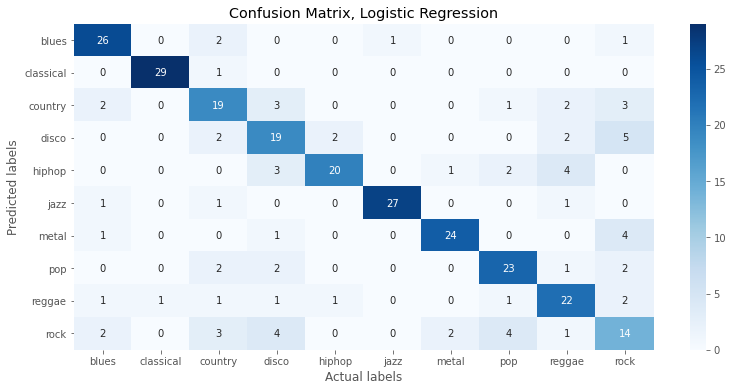

In [54]:
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(X_train, y_train)

# Predict
y_pred = lr_classifier.predict(X_test)

save_scores('lr', y_pred)
plot_confusion_matrix(y_pred, title='Confusion Matrix, Logistic Regression', save_path=RESULTS_DIR+'cm_lr.png')

## Random Forest

Accuracy: 0.7300
Precision macro: 0.7388
Recall macro: 0.7300
F1 score macro: 0.7305
ROC AUC macro: 0.8500



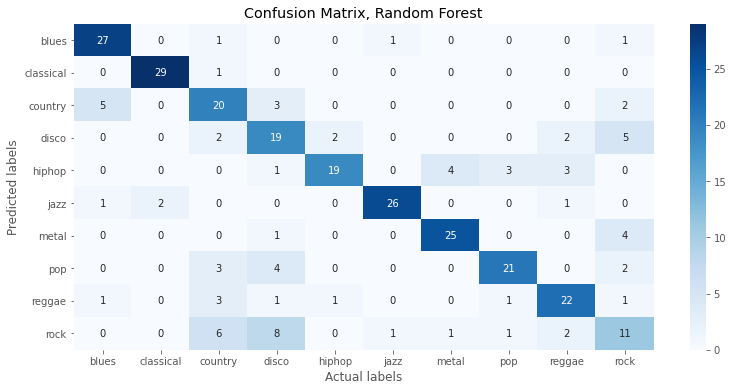

In [55]:
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(X_train, y_train)

# Predict
y_pred = rf_classifier.predict(X_test)

save_scores('rf', y_pred)
plot_confusion_matrix(y_pred, title='Confusion Matrix, Random Forest', save_path=RESULTS_DIR+'cm_rf.png')

## Gradient Boosting

Accuracy: 0.7767
Precision macro: 0.7829
Recall macro: 0.7767
F1 score macro: 0.7754
ROC AUC macro: 0.8759



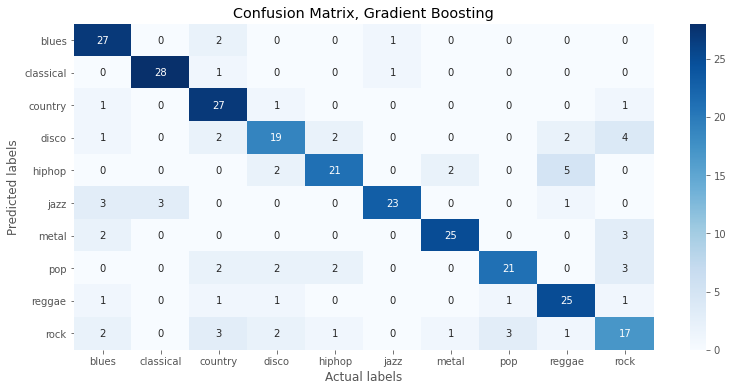

In [58]:
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, 
                                   n_estimators=500, subsample=0.8, num_class=10)
xgb_classifier.fit(X_train, y_train)

# Predict
y_pred = xgb_classifier.predict(X_test)

save_scores('xgb', y_pred)
plot_confusion_matrix(y_pred, title='Confusion Matrix, Gradient Boosting', save_path=RESULTS_DIR+'cm_xgb.png')

## Support Vector Machines

Accuracy: 0.7467
Precision macro: 0.7636
Recall macro: 0.7467
F1 score macro: 0.7487
ROC AUC macro: 0.8593



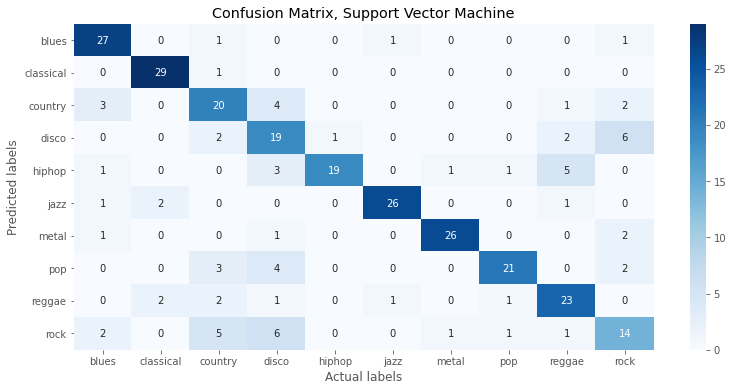

In [59]:
# Train
svm_classifier = SVC(kernel='rbf', decision_function_shape='ovr')
svm_classifier.fit(X_train, y_train)

# Predict
y_pred = svm_classifier.predict(X_test)

save_scores('svm', y_pred)
plot_confusion_matrix(y_pred, title='Confusion Matrix, Support Vector Machine', save_path=RESULTS_DIR+'cm_svm.png')

## K-Nearest Neighbors

Accuracy: 0.7200
Precision macro: 0.7395
Recall macro: 0.7200
F1 score macro: 0.7231
ROC AUC macro: 0.8444



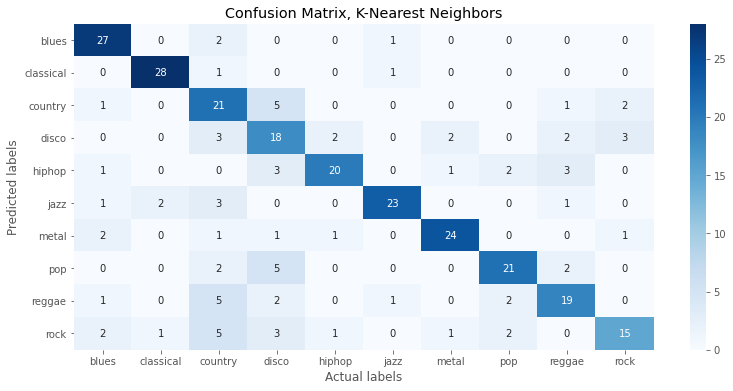

In [60]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(X_train, y_train)

# Predict
y_pred = knn_classifier.predict(X_test)

save_scores('knn', y_pred)
plot_confusion_matrix(y_pred, title='Confusion Matrix, K-Nearest Neighbors', save_path=RESULTS_DIR+'cm_knn.png')